Gesture Recognition for Smart TV Control
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Problem Statement:

The goal is to enhance user interaction with smart televisions by developing a system that can recognize and interpret five specific hand gestures to control various TV functions. These gestures and their corresponding actions are:

1. **Thumbs Up**: Increase the TV volume.
2. **Thumbs Down**: Decrease the TV volume.
3. **Left Swipe**: Rewind the video by 10 seconds.
4. **Right Swipe**: Fast forward the video by 10 seconds.
5. **Stop**: Pause the video.

The input consists of video recordings, where each video is a short clip capturing a specific gesture performed by different users. These videos are divided into a sequence of 30 frames, each representing one moment in the gesture.

### Objective
The objective is to create a machine learning model that can recognize one of the five gestures from a sequence of video frames. The model should be trained on the 'train' folder and evaluated on the 'val' folder to ensure good generalization. The final performance will be tested on the 'test' set.

### Steps to Solve the Problem

1. **Data Preprocessing**: 
   - Load and prepare the video data, converting it into a format suitable for training (such as sequences of images/frames).
   - Apply preprocessing like resizing, normalization, and augmentation to enhance model performance.
   
2. **Model Architecture**:
   - Design a model for sequence recognition, such as using a Convolutional Neural Network (CNN) for spatial feature extraction followed by a Recurrent Neural Network (RNN) or a 3D CNN for temporal sequence learning.
   
3. **Model Training**:
   - Train the model on the 'train' dataset while monitoring the performance on the 'val' dataset to prevent overfitting and ensure the model generalizes well.
   
4. **Evaluation**:
   - After training, evaluate the model's performance on the 'val' dataset and adjust parameters accordingly.

5. **Test Performance**:
   - Finally, after tuning the model, evaluate its performance on the 'test' set to assess its real-world accuracy.

### Requirements

1. **Input**: Video clips, each consisting of 30 frames, labeled with one of five gestures.
2. **Output**: The model should output the gesture class for each video clip (one of the five gestures).
3. **Metrics**: The model's performance will be evaluated using accuracy and other relevant metrics.

By the end of this project, the goal is to develop a robust gesture recognition system that allows users to interact with their smart TVs through simple hand gestures.

## Import Libraries

In [1]:
import numpy as np
import os
from skimage import io, transform
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Conv3D,
    MaxPooling2D,
    MaxPooling3D,
    LSTM,
    GRU,
    Flatten,
    TimeDistributed,
    BatchNormalization,
    Activation,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16, MobileNetV2
from sys import getsizeof


### We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn

rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

# Initialise source_path
source_path='datasets/Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
total_frames = 30 
num_of_classes = 5

In [5]:
# Function to Resize and Crop Images Based on Specific Dimensions
# Supports frames or images with dimensions 360x360 and 120x160; raises an exception for unsupported dimensions
# Ensuring a Specific Aspect Ratio (130x120) :

def resize_image(image, image_height_out, image_width_out):
    height, width = image.shape[0], image.shape[1]
    # Case 1: If image is 360x360
    if height == 360 and width == 360:
        image = transform.resize(image, (120, 120))

        # Center crop a region around 120x120
        height_center, width_center = 60, 60
        image = image[
            (height_center - 60) : (height_center + 70),
            (width_center - 50) : (width_center + 70),
        ]

    # Case 2: If video is 120x160
    elif height == 120 and width == 160:
        # Center crop to capture a consistent 100x100 area
        height_center = height // 2  # 60
        width_center = width // 2  # 80
        image = image[
            (height_center - 50) : (height_center + 50),
            (width_center - 50) : (width_center + 50),
        ]

    # Case 3: Unsupported dimensions
    else:
        raise ValueError(
            f"Unsupported image dimensions: {height}x{width}. "
            "Expected dimensions are 360x360 or 120x160."
        )

    image = transform.resize(image, (image_height_out, image_width_out))
    return image


In [6]:
def plot_original_crop_images(paths, image_height, image_width):
    for index, path in enumerate(paths):
        image = io.imread(path)
        image_cropped = resize_image(
            image, image_height_out=image_height, image_width_out=image_width
        )
        
        plt.figure(figsize=[12, 12])
        plt.subplot(5, 2, index * 2 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        
        plt.subplot(5, 2, index * 2 + 2)
        plt.imshow(image_cropped)
        plt.title("Modified Image")
    plt.show()


In [7]:
def generator(source_path, folder_list, batch_size, img_idx, image_height, image_width):
    print("Source path = ", source_path, "; batch size =", batch_size)
    img_idx = (
        img_idx  # create a list of image numbers you want to use for a particular video
    )
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros(
                (batch_size, len(img_idx), image_height, image_width, 3)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros(
                (batch_size, 5)
            )  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(
                    source_path + "/" + t[folder + (batch * batch_size)].split(";")[0]
                ) 
                for idx, item in enumerate(
                    img_idx
                ): 
                    image = io.imread(
                        source_path
                        + "/"
                        + t[folder + (batch * batch_size)].strip().split(";")[0]
                        + "/"
                        + imgs[item]
                    ).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(
                        image,
                        image_height_out=image_height,
                        image_width_out=image_width,
                    )

                    batch_data[folder, idx, :, :, 0] = image[
                        :, :, 0
                    ]  # normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = image[
                        :, :, 1
                    ]  # normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = image[
                        :, :, 2
                    ]  # normalise and feed in the image

                batch_labels[
                    folder, int(t[folder + (batch * batch_size)].strip().split(";")[2])
                ] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do

        if len(folder_list) != batch_size * num_batches:
            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros(
                (batch_size, len(img_idx), image_height, image_width, 3)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros(
                (batch_size, 5)
            )  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(
                    source_path + "/" + t[folder + (batch * batch_size)].split(";")[0]
                )  # read all the images in the folder
                for idx, item in enumerate(
                    img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(
                        source_path
                        + "/"
                        + t[folder + (batch * batch_size)].strip().split(";")[0]
                        + "/"
                        + imgs[item]
                    ).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(
                        image,
                        image_height_out=image_height,
                        image_width_out=image_width,
                    )

                    batch_data[folder, idx, :, :, 0] = image[
                        :, :, 0
                    ]  # normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = image[
                        :, :, 1
                    ]  # normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = image[
                        :, :, 2
                    ]  # normalise and feed in the image

                batch_labels[
                    folder, int(t[folder + (batch * batch_size)].strip().split(";")[2])
                ] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do


#### Specifically, the videos have two different resolution types: either 360x360 or 120x160, depending on the webcam used to capture the footage.

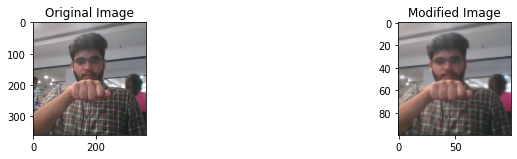

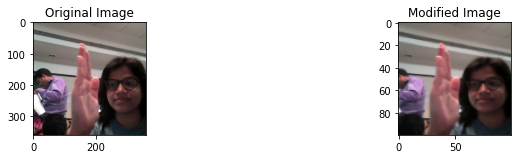

In [8]:
full_image_paths = [
    "datasets/Project_data/train/WIN_20180907_15_40_55_Pro_Thumbs Up_new/WIN_20180907_15_40_55_Pro_00008.png",
    "datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00052.png",
]

plot_original_crop_images(full_image_paths, image_height=100, image_width=100)


In [9]:
curr_dt_time = datetime.datetime.now()
train_path = "datasets/Project_data/train"
val_path = "datasets/Project_data/val"
num_train_sequences = len(train_doc)

print("# training sequences =", num_train_sequences)
num_val_sequences = len(val_doc)

print("# validation sequences =", num_val_sequences)
num_epochs = 20  # choose the number of epochs
print("# epochs =", num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [18]:
# Dictionary to store histories
models_history = {}

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

### Data Pre-processor:

In [10]:
class DataPreprocessor:
    def __init__(
        self,
        image_height=120,
        image_width=120,
        num_of_frames=15,
        batch_size=40,
        num_epochs=10,
    ):
        # Store hyperparameters for data preprocessing
        self.image_height = image_height
        self.image_width = image_width
        self.num_of_frames = num_of_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def set_paths(
        self,
        train_path="datasets/Project_data/train",
        val_path="datasets/Project_data/val",
    ):
        # Paths for training and validation data
        self.train_path = train_path
        self.val_path = val_path

    def calculate_input_shape(self):
        # Calculate and return input shape for models based on number of frames and image dimensions
        self.input_shape = (self.num_of_frames, self.image_height, self.image_width, 3)
        return self.input_shape

    def calculate_img_idx(self, total_frames):
        # Calculate evenly spaced frame indices based on the total number of frames in each video
        self.img_idx = np.linspace(0, total_frames - 1, self.num_of_frames).astype(int)
        return self.img_idx

    def get_data_generators(self, generator, train_doc, val_doc):
        # Initialize train and validation data generators
        self.train_generator = generator(
            self.train_path,
            train_doc,
            self.batch_size,
            self.img_idx,
            self.image_height,
            self.image_width,
        )
        self.val_generator = generator(
            self.val_path,
            val_doc,
            self.batch_size,
            self.img_idx,
            self.image_height,
            self.image_width,
        )
        return self.train_generator, self.val_generator

    def display_summary(self):
        # Display configuration summary
        print("=== Data Preprocessing Summary ===")
        print(f"Image Height: {self.image_height}")
        print(f"Image Width: {self.image_width}")
        print(f"Frames per Video: {self.num_of_frames}")
        print(f"Batch Size: {self.batch_size}")
        print(f"Number of Epochs: {self.num_epochs}")
        print(f"Training Path: {self.train_path}")
        print(f"Validation Path: {self.val_path}")
        print(f"Input Shape: {self.input_shape}")
        print(f"Frame Indices: {self.img_idx}")
        print("__________________________________________")

    def initializePreprocessData(self, total_frames, generator, train_doc, val_doc):
        # Call all methods to calculate necessary configurations and print a summary
        self.calculate_input_shape()
        self.calculate_img_idx(total_frames)
        self.get_data_generators(generator, train_doc, val_doc)
        num_train_sequences = len(train_doc)
        num_val_sequences = len(val_doc)
        self.display_summary()


### Conv3D Base Model Class

This class provides key configurations, enabling you to customize layer sizes, kernel sizes, dropout rates, and the optimizer.

In [11]:
class Conv3DBaseModel:
    def __init__(
        self,
        input_shape,
        num_classes,
        optimizer_type="SGD",
        optimizer_params=None,
        model_name="model_init",
    ):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params or {}

    def build_model(
        self,
        conv_layers=[8, 16, 32],
        maxpool_layers=[1, 1, 1],
        kernel_size=(3, 3, 3),
        dense_units=[128],
        dropout_rate=None,
    ):
        if len(conv_layers) != len(maxpool_layers):
            raise ValueError(
                "Configuration Error: 'conv_layers' and 'maxpool_layers' must have the same length."
            )
        # Initialize model
        model = Sequential()

        # Add Conv3D layers
        for i, filters in enumerate(conv_layers):
            conv_name = f"Conv3D_{i+1}_{filters}F"
            if i == 0:
                model.add(
                    Conv3D(
                        filters,
                        kernel_size=kernel_size,
                        input_shape=self.input_shape,
                        padding="same",
                        name=conv_name,
                    )
                )
            else:
                model.add(
                    Conv3D(
                        filters, kernel_size=kernel_size, padding="same", name=conv_name
                    )
                )
            model.add(BatchNormalization(name=f"BatchNorm_{conv_name}"))
            model.add(Activation("relu", name=f"ReLU_{conv_name}"))
            if maxpool_layers[i] == 1:
                maxpool_name = f"MaxPool_{conv_name}"
                model.add(MaxPooling3D(pool_size=(2, 2, 2), name=maxpool_name))

        # Flatten and add Dense layers
        model.add(Flatten())
        for j, units in enumerate(dense_units):
            dense_name = f"Dense_{j+1}_{units}N"
            model.add(Dense(units, name=dense_name))
            model.add(BatchNormalization(name=f"BatchNorm_{dense_name}"))
            model.add(Activation("relu", name=f"ReLU_{dense_name}"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j], name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == "SGD":
            default_params = {"learning_rate": 0.001, "momentum": 0.7, "nesterov": True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == "Adam":
            default_params = {
                "learning_rate": 0.001,
                "beta_1": 0.9,
                "beta_2": 0.999,
                "epsilon": 1e-7,
            }
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == "RMSprop":
            default_params = {
                "learning_rate": 0.001,
                "rho": 0.9,
                "momentum": 0.0,
                "epsilon": 1e-7,
            }
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(
            optimizer=optimiser,
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"],
        )
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = (
            self.model_name
            + "_"
            + str(curr_dt_time).replace(" ", "").replace(":", "_")
            + "/"
        )
        # Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(
            filepath,
            monitor="val_loss",
            verbose=1,
            save_best_only=False,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
        )

        LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=1
        )

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self, config):
        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_model(
        self,
        config,
        train_generator,
        val_generator,
        num_train_sequences,
        num_val_sequences,
        batch_size,
        num_epochs,
    ):
        print("\n--- Running Model ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0,
        )
        print("-- model training completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history["categorical_accuracy"]
        val_acc = self.history.history["val_categorical_accuracy"]

        # Extract loss and validation loss from training history
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label="Training Accuracy")  # Plot training accuracy
        plt.plot(
            epochs_range, val_acc, label="Validation Accuracy"
        )  # Plot validation accuracy
        plt.legend(loc="lower right")  # Position the legend
        plt.title("Training and Validation Accuracy")  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label="Training Loss")  # Plot training loss
        plt.plot(
            epochs_range, val_loss, label="Validation Loss"
        )  # Plot validation loss
        plt.legend(loc="upper right")  # Position the legend
        plt.title("Training and Validation Loss") 

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history["categorical_accuracy"])
        max_val_acc = max(self.history.history["val_categorical_accuracy"])
        
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history["loss"])
        min_val_loss = min(self.history.history["val_loss"])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


### CNN and LSTM Model Class

In [12]:
class RNNCNNModel:
    def __init__(
        self,
        input_shape,
        num_classes,
        rnn_type="LSTM",
        optimizer_type="SGD",
        optimizer_params=None,
        model_name="RNNCNNModel",
    ):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.rnn_type = rnn_type
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params or {}

    def build_model(
        self,
        conv_layers=[16, 32, 64],
        maxpool_layers=[1, 1, 1],
        kernel_size=(3, 3),
        rnn_units=64,
        dense_units=[128],
        dropout_rate=0.25,
    ):
        if len(conv_layers) != len(maxpool_layers):
            raise ValueError(
                "Configuration Error: 'conv_layers' and 'maxpool_layers' must have the same length."
            )

        # Initialize model
        model = Sequential()

        # Add TimeDistributed Conv2D layers
        for i, filters in enumerate(conv_layers):
            conv_name = f"Conv2D_{i+1}_{filters}F"
            if i == 0:
                model.add(
                    TimeDistributed(
                        Conv2D(filters, kernel_size=kernel_size, padding="same"),
                        input_shape=self.input_shape,
                        name=conv_name,
                    )
                )
            else:
                model.add(
                    TimeDistributed(
                        Conv2D(filters, kernel_size=kernel_size, padding="same"),
                        name=conv_name,
                    )
                )
            model.add(
                TimeDistributed(BatchNormalization(), name=f"BatchNorm_{conv_name}")
            )
            model.add(TimeDistributed(Activation("relu"), name=f"ReLU_{conv_name}"))
            if maxpool_layers[i] == 1:
                model.add(
                    TimeDistributed(
                        MaxPooling2D(pool_size=(2, 2)), name=f"MaxPool_{conv_name}"
                    )
                )

        # Flatten and add RNN layer
        model.add(TimeDistributed(Flatten(), name="Flatten_Layer"))
        if self.rnn_type == "LSTM":
            model.add(
                LSTM(rnn_units, return_sequences=False, name=f"LSTM_{rnn_units}_Units")
            )
        elif self.rnn_type == "GRU":
            model.add(
                GRU(rnn_units, return_sequences=False, name=f"GRU_{rnn_units}_Units")
            )
        else:
            raise ValueError("Unsupported RNN type: choose 'LSTM' or 'GRU'.")

        # Add Dense layers
        for j, units in enumerate(dense_units):
            model.add(Dense(units, activation="relu", name=f"Dense_{j+1}_{units}N"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j], name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == "SGD":
            default_params = {"learning_rate": 0.001, "momentum": 0.7, "nesterov": True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == "Adam":
            default_params = {
                "learning_rate": 0.001,
                "beta_1": 0.9,
                "beta_2": 0.999,
                "epsilon": 1e-7,
            }
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == "RMSprop":
            default_params = {
                "learning_rate": 0.001,
                "rho": 0.9,
                "momentum": 0.0,
                "epsilon": 1e-7,
            }
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(
            optimizer=optimiser,
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"],
        )
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = (
            self.model_name
            + "_"
            + str(curr_dt_time).replace(" ", "").replace(":", "_")
            + "/"
        )
        # Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(
            filepath,
            monitor="val_loss",
            verbose=1,
            save_best_only=False,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
        )

        LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=1
        )

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self, config):
        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            rnn_units=config["rnn_units"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        
        print(self.model.summary())
        return self.model

    def run_model(
        self,
        config,
        train_generator,
        val_generator,
        num_train_sequences,
        num_val_sequences,
        batch_size,
        num_epochs,
    ):
        """Run a single model based on the provided configuration."""
        print("\n--- Running model ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            rnn_units=config["rnn_units"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0,
        )
        print("--- Model training completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history["categorical_accuracy"]
        val_acc = self.history.history["val_categorical_accuracy"]

        # Extract loss and validation loss from training history
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label="Training Accuracy")  # Plot training accuracy
        plt.plot(
            epochs_range, val_acc, label="Validation Accuracy"
        )  # Plot validation accuracy
        plt.legend(loc="lower right")  # Position the legend
        plt.title("Training and Validation Accuracy")  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label="Training Loss")  # Plot training loss
        plt.plot(
            epochs_range, val_loss, label="Validation Loss"
        )  # Plot validation loss
        plt.legend(loc="upper right")  # Position the legend
        plt.title("Training and Validation Loss")  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history["categorical_accuracy"])
        max_val_acc = max(self.history.history["val_categorical_accuracy"])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history["loss"])
        min_val_loss = min(self.history.history["val_loss"])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


### VGG16 , MobileNetV2 or ResNet18 Imagenet and LSTM Model Class

In [13]:
class RNNCNN_ImageNet:
    def __init__(
        self,
        input_shape,
        num_classes,
        rnn_type="LSTM",
        imagenet_type="VGG16",
        imagenet_trainable_layers=0,
        optimizer_type="SGD",
        optimizer_params=None,
        model_name="RNNCNN_VGGNet",
    ):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.rnn_type = rnn_type
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.imagenet_type = imagenet_type
        self.imagenet_trainable_layers = imagenet_trainable_layers
        self.optimizer_params = optimizer_params or {}

    def build_model(
        self,
        rnn_units=[64],
        rnn_dropout_rate=[0.25],
        dense_units=[128],
        dropout_rate=[0.25],
    ):
        # Initialize Sequential model
        model = Sequential()

        # Add Input layer to specify input shape explicitly at the start
        model.add(
            Input(shape=self.input_shape, name="Input_Layer")
        )  # Add Input layer with your specified shape

        # Load imagenet without top layers, include weights but freeze them
        imagenet_layer_name = f"{self.imagenet_type}_Feature_Extractor"
        if self.imagenet_type == "VGG16":
            imagenet_model = VGG16(
                weights="imagenet", include_top=False, input_shape=self.input_shape[1:]
            )
        elif self.imagenet_type == "ResNet18":
            imagenet_model = ResNet18(
                weights="imagenet", include_top=False, input_shape=self.input_shape[1:]
            )
        elif self.imagenet_type == "MobileNetV2":
            imagenet_model = MobileNetV2(
                weights="imagenet", include_top=False, input_shape=self.input_shape[1:]
            )
        else:
            raise ValueError(
                "Unsupported imagenet type: choose 'VGG16' or 'ResNet18' or 'MobileNetV2' ."
            )
        # Ignore trainable weights
        if self.imagenet_trainable_layers == 0:
            for layer in imagenet_model.layers:
                layer.trainable = False
        elif self.imagenet_trainable_layers:
            for layer in imagenet_model.layers[
                : self.imagenet_trainable_layers
            ]:  # adjust layer count based on your model's layers
                layer.trainable = False
            for layer in imagenet_model.layers[self.imagenet_trainable_layers :]:
                layer.trainable = True
        else:
            raise ValueError(
                "Unsupported imagenet trainable layers : choose 'NA' or 'after_100' ."
            )

        # Wrap imagenet in TimeDistributed layer to apply it to each time step in sequence
        model.add(TimeDistributed(imagenet_model, name=imagenet_layer_name))

        # Add Batch Normalization layer
        # model.add(TimeDistributed(BatchNormalization(), name=f"BatchNorm_{imagenet_layer_name}"))
        # Add Max Pooling to reduce dimensions
        # model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name=f"MaxPool_{imagenet_layer_name}"))

        # Add Global Average Pooling to reduce dimensions
        model.add(
            TimeDistributed(
                GlobalAveragePooling2D(), name="Global_Average_Pooling_Layer"
            )
        )

        # Flatten and add RNN layer
        # model.add(TimeDistributed(Flatten(), name="Flatten_Layer"))

        # LSTM or GRU cells
        for i, units in enumerate(rnn_units):
            return_sequences = (
                True if i < len(rnn_units) - 1 else False
            )  # Only final RNN layer should have return_sequences=False
            if self.rnn_type == "LSTM":
                model.add(
                    LSTM(
                        units,
                        return_sequences=return_sequences,
                        name=f"LSTM_{i+1}_{units}_Units",
                    )
                )
            elif self.rnn_type == "GRU":
                model.add(
                    GRU(
                        units,
                        return_sequences=return_sequences,
                        name=f"GRU_{i+1}_{units}_Units",
                    )
                )
            else:
                raise ValueError("Unsupported RNN type: choose 'LSTM' or 'GRU'.")

            # Add dropouts
            if rnn_dropout_rate[i] != 0:
                rnn_dropout_name = (
                    f"Dropout_{i+1}_{int(rnn_dropout_rate[i]*100)}_percent"
                )
                model.add(Dropout(rnn_dropout_rate[i], name=rnn_dropout_name))

        # Add Dense layers
        for j, units in enumerate(dense_units):
            model.add(Dense(units, activation="relu", name=f"Dense_{j+1}_{units}N"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j], name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == "SGD":
            default_params = {"learning_rate": 0.001, "momentum": 0.7, "nesterov": True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == "Adam":
            default_params = {
                "learning_rate": 0.001,
                "beta_1": 0.9,
                "beta_2": 0.999,
                "epsilon": 1e-7,
            }
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == "RMSprop":
            default_params = {
                "learning_rate": 0.001,
                "rho": 0.9,
                "momentum": 0.0,
                "epsilon": 1e-7,
            }
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(
            optimizer=optimiser,
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"],
        )
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = (
            self.model_name
            + "_"
            + str(curr_dt_time).replace(" ", "").replace(":", "_")
            + "/"
        )
        # Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(
            filepath,
            monitor="val_loss",
            verbose=1,
            save_best_only=False,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
        )

        LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=1
        )

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self, config):
        # Initialize and build the model
        model = self.build_model(
            rnn_units=config["rnn_units"],
            rnn_dropout_rate=config["rnn_dropout_rate"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_model(
        self,
        config,
        train_generator,
        val_generator,
        num_train_sequences,
        num_val_sequences,
        batch_size,
        num_epochs,
    ):
        """Run a single model based on the provided configuration."""
        print("\n--- Running model ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            rnn_units=config["rnn_units"],
            rnn_dropout_rate=config["rnn_dropout_rate"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"],
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0,
        )
        print("--- Model training completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history["categorical_accuracy"]
        val_acc = self.history.history["val_categorical_accuracy"]

        # Extract loss and validation loss from training history
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label="Training Accuracy")  # Plot training accuracy
        plt.plot(
            epochs_range, val_acc, label="Validation Accuracy"
        )  # Plot validation accuracy
        plt.legend(loc="lower right")  # Position the legend
        plt.title("Training and Validation Accuracy")  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label="Training Loss")  # Plot training loss
        plt.plot(
            epochs_range, val_loss, label="Validation Loss"
        )  # Plot validation loss
        plt.legend(loc="upper right")  # Position the legend
        plt.title("Training and Validation Loss")  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history["categorical_accuracy"])
        max_val_acc = max(self.history.history["val_categorical_accuracy"])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history["loss"])
        min_val_loss = min(self.history.history["val_loss"])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


## Identifying Optimal Model Parameters:
1. Batch Size
2. Frame Count
3. Image Shape
for Efficient Model Training

### Steps:
- Conducted models with different batch sizes, frame counts, and image shapes to assess performance.
- Trained each configuration for 2 epochs to monitor GPU utilization, RAM usage, and training time.
- The insights gained will guide the selection of optimal parameters for building the final model.

### Model 1:
- image_height=120,
- image_width=120,
- num_of_frames=30,
- batch_size=40,
- num_epochs=2

In [15]:
# Initialize the DataPreprocessor

preprocessor = DataPreprocessor(
    image_height=120, image_width=120, num_of_frames=30, batch_size=40, num_epochs=2
)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(
    total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc
)


=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 30
Batch Size: 40
Number of Epochs: 2
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (30, 120, 120, 3)
Frame Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
__________________________________________


In [16]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.5, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_1",
)

# Running the model
model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---


2025-03-02 12:17:48.575676: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-02 12:17:48.575738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Directory model_1_2025-03-0212_17_48.743101/ is ready.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 30, 120, 120, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 30, 120, 120, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 15, 60, 60, 16)   0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 15, 60, 60, 32)    13856     
 

2025-03-02 12:17:59.900377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.6353 - categorical_accuracy: 0.3348 Source path =  datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_1_2025-03-0212_17_48.743101/model-01-11.94.keras
17/17 [==============================] - 197s 12s/step - loss: 1.6353 - categorical_accuracy: 0.3348 - val_loss: 11.9437 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.2567 - categorical_accuracy: 0.4552
Epoch 00002: saving model to model_1_2025-03-0212_17_48.743101/model-02-5.75.keras
17/17 [==============================] - 101s 6s/step - loss: 1.2567 - categorical_accuracy: 0.4552 - val_loss: 5.7504 - val_categorical_accuracy: 0.2500 - lr: 0.0010
-- model training completed ---



(<keras.callbacks.History at 0x7f0bedf1c880>,
 'model_1_2025-03-0212_17_48.743101/')

In [17]:
# Calculate memory utilization for the given array size in gigabytes

memory_util_gigs = getsizeof(np.zeros((50, 16, 30, 120, 120))) / (1024**3)
print(f"Memory utilization is {memory_util_gigs:.2f} GB")


Memory utilization is 2.57 GB


### Model 2 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=60,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(
    image_height=120, image_width=120, num_of_frames=15, batch_size=60, num_epochs=2
)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(
    total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc
)


=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 60
Number of Epochs: 2
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_2")

# Running the model
model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Model ---
Directory model_2_2025-03-0212_22_56.043357/ is ready.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 15, 120, 120, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 15, 120, 120, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 7, 60, 60, 16)    0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 7, 60,

(<keras.callbacks.History at 0x7f0bdb572d90>,
 'model_2_2025-03-0212_22_56.043357/')

### Model 3 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.5, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_3",
)

# Running the model
model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---
Directory model_3_2025-03-0212_24_44.218293/ is ready.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 15, 120, 120, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 15, 120, 120, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 7, 60, 60, 16)    0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 7, 60,

(<keras.callbacks.History at 0x7f0c1043ecd0>,
 'model_3_2025-03-0212_24_44.218293/')

### Model 4 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=40, num_epochs=2)

# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.5, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_4",
)

# Running the model
model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---
Directory model_4_2025-03-0212_27_08.569725/ is ready.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 15, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 15, 100, 100, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 7, 50, 50, 16)    0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 7, 50,

(<keras.callbacks.History at 0x7f0bf22928b0>,
 'model_4_2025-03-0212_27_08.569725/')

### Model 5 -
- image_height=160,
- image_width=160,
- num_of_frames=20,
- batch_size=30,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(
    image_height=160, image_width=160, num_of_frames=20, batch_size=30, num_epochs=2
)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(
    total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc
)


=== Data Preprocessing Summary ===
Image Height: 160
Image Width: 160
Frames per Video: 20
Batch Size: 30
Number of Epochs: 2
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 160, 160, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.5, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_5",
)

# Running the model
model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---
Directory model_5_2025-03-0212_29_20.499375/ is ready.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 20, 160, 160, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 20, 160, 160, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 10, 80, 80, 16)   0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 10, 80

(<keras.callbacks.History at 0x7f0bdb272ee0>,
 'model_5_2025-03-0212_29_20.499375/')

## Observation and Decisions:
- From the above models, it's clear that "image resolution" and the "number of frames in each sequence" have a greater impact on training time than batch size.
- Based on this, we can keep the batch size between 20-40.
- For the number of frames, a range of 15-20 frames appears suitable.
- We'll adjust the resolution to either 100x100 or 120x120 depending on the model’s performance.

## Approach 1: Conv3D Models


Will start with this basic configuration

- Number of frames: 15
- Batch size: 32
- Image resolution: 100 x 100
- Number of epoch : 50
- Optimizer :SGD
- Equal CNN and MaxPooling Layers

### Model 1 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50
- less dropouts

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(
    image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50
)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(
    total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc
)


=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.25, 0.10],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_1",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)

# Store history in the dictionary for future comparision
models_history[model_name] = history



--- Running Model ---
Directory model_1_2025-03-0212_32_03.266914/ is ready.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 15, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 15, 100, 100, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 7, 50, 50, 16)    0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 7, 50,

(0.8907563090324402, 0.8125, 0.5129475593566895, 0.6853000521659851)


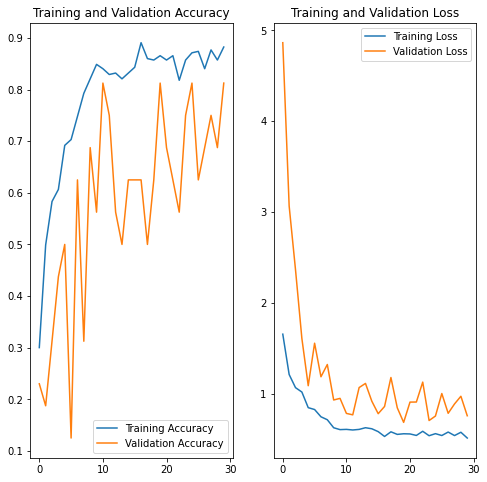

In [ ]:
# Evaluate models
print(model.evaluate_model())

model.plot_history()

In [ ]:
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>}

### Model 2 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50
- adjuster dropouts

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.5, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_2",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)

# Store history in the dictionary for future comparision
models_history[model_name] = history



--- Running Model ---
Directory model_2_2025-03-0212_52_16.462821/ is ready.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 15, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 15, 100, 100, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 7, 50, 50, 16)    0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 7, 50,

(0.8095238208770752, 0.875, 0.6411067247390747, 0.6193331480026245)


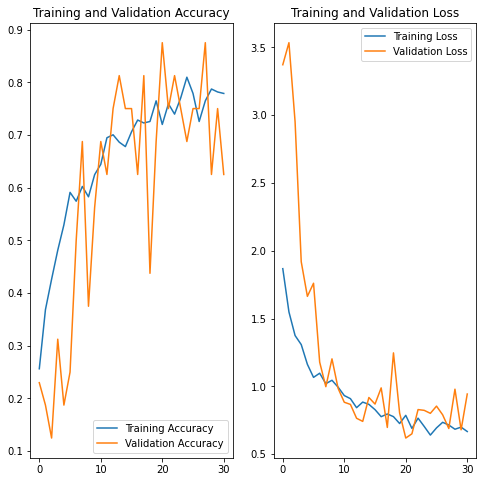

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>}

### Model 3 -
- image_height=100, 
- image_width=100, 
- num_of_frames=20,
- batch_size=32,
- num_epochs=50
- optimizer = SGD

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers": [1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.50, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_3",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)

# Store history in the dictionary for future comparision
models_history[model_name] = history



--- Running Model ---
Directory model_3_2025-03-0213_14_57.115538/ is ready.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 20, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 20, 100, 100, 16)  0        
 on)                                                             
                                                                 
 MaxPool_Conv3D_1_16F (MaxPo  (None, 10, 50, 50, 16)   0         
 oling3D)                                                        
                                                                 
 Conv3D_2_32F (Conv3D)       (None, 10, 50

(0.8291316628456116, 0.9375, 0.5942206978797913, 0.4867466688156128)


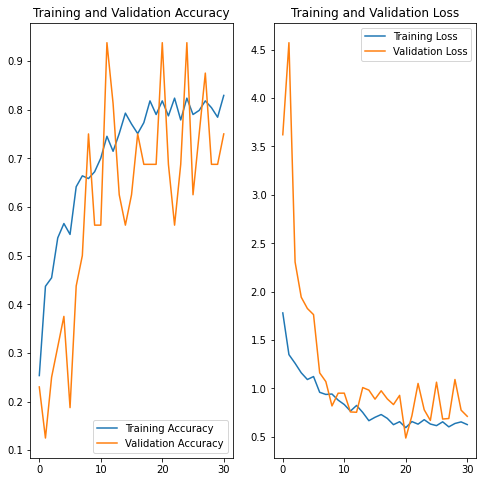

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>}

### Model 4 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32, 
- num_epochs=50 
- More CNN Layers , and alternate MaxPoolLayers in Conv layers

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers": [0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.50, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_4",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---
Directory model_4_2025-03-0213_42_43.549779/ is ready.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 20, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 20, 100, 100, 16)  0        
 on)                                                             
                                                                 
 Conv3D_2_16F (Conv3D)       (None, 20, 100, 100, 16)  6928      
                                                                 
 BatchNorm_Conv3D_2_16F (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                         

(0.686274528503418, 0.75, 0.8959434628486633, 0.8450176119804382)


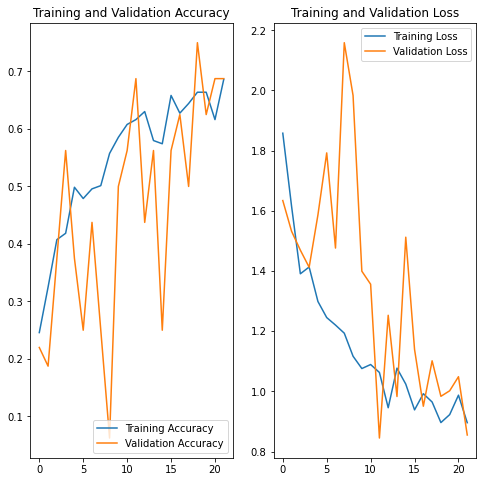

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
models_history[model_name] = history
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>,
 'model_4_2025-03-0213_42_43.549779/': <keras.callbacks.History at 0x7f0bd9303940>}

### Model 5 -
- image_height=100, 
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50
- More CNN Layers , and alternate MaxPoolLayers in Conv layers
- Optimizer = "Adam"
- More Dense Layers 
- Learning Rate - 0.0005

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers": [0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [256, 128, 64],
    "dropout_rate": [0.50, 0.40, 0.30],
}

# Optimizer configuration
optimizer_type = "Adam"
optimizer_params = {
    "learning_rate": 0.0005,
    "beta_1": 0.9,
    "beta_2": 0.999,
    "epsilon": 1e-7,
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = Conv3DBaseModel(
    preprocessor.input_shape,
    num_of_classes,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_6",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running Model ---
Directory model_6_2025-03-0214_03_12.423794/ is ready.
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv3D_1_16F (Conv3D)       (None, 20, 100, 100, 16)  1312      
                                                                 
 BatchNorm_Conv3D_1_16F (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 ReLU_Conv3D_1_16F (Activati  (None, 20, 100, 100, 16)  0        
 on)                                                             
                                                                 
 Conv3D_2_16F (Conv3D)       (None, 20, 100, 100, 16)  6928      
                                                                 
 BatchNorm_Conv3D_2_16F (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                         

In [ ]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>,
 'model_4_2025-03-0213_42_43.549779/': <keras.callbacks.History at 0x7f0bd9303940>,
 'model_6_2025-03-0214_03_12.423794/': <keras.callbacks.History at 0x7f0bda60e0d0>}

## Approach 2 : Conv2D + RNN Models

Will start with this basic configuration

- Number of frames: 20
- Batch size: 32
- Image resolution: 100 x 100
- Number of epoch : 50
- Optimizer : SGD
- CNN and LSTM layers

### Model 1 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50,
- Optimizer = SGD
- 4 Conv2D , MaxPooling layers
- 2 Dense layers with usual dropouts
- LSTM : 128 rnn units

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)


=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# model configuration
model_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers": [1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [128, 64],
    "dropout_rate": [0.50, 0.25],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# RNN type
rnn_type = "LSTM"

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = RNNCNNModel(
    preprocessor.input_shape,
    num_of_classes,
    rnn_type=rnn_type,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_1",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running model ---
Directory model_1_2025-03-0214_41_16.135360/ is ready.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1_16F (TimeDistribut  (None, 20, 100, 100, 16)  448      
 ed)                                                             
                                                                 
 BatchNorm_Conv2D_1_16F (Tim  (None, 20, 100, 100, 16)  64       
 eDistributed)                                                   
                                                                 
 ReLU_Conv2D_1_16F (TimeDist  (None, 20, 100, 100, 16)  0        
 ributed)                                                        
                                                                 
 MaxPool_Conv2D_1_16F (TimeD  (None, 20, 50, 50, 16)   0         
 istributed)                                                     
                                         

(0.48739495873451233, 0.8125, 1.3226943016052246, 1.2055704593658447)


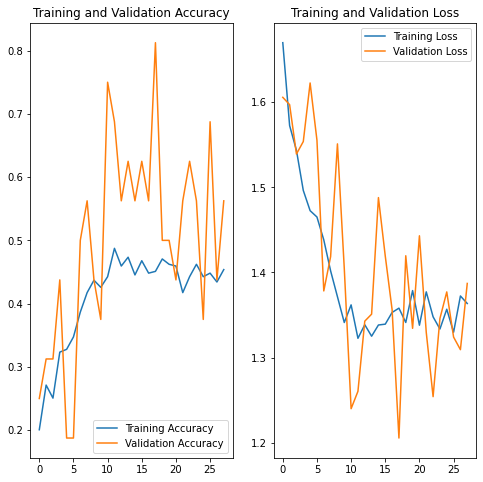

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>,
 'model_4_2025-03-0213_42_43.549779/': <keras.callbacks.History at 0x7f0bd9303940>,
 'model_6_2025-03-0214_03_12.423794/': <keras.callbacks.History at 0x7f0bda60e0d0>,
 'model_1_2025-03-0214_41_16.135360/': <keras.callbacks.History at 0x7f0bd8a56a90>}

### Model 2 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50,
- Optimizer = SGD
- 4 Conv2D , MaxPooling layers
- 1 LSTM cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers": [1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50],
}

# Optimizer configuration
optimizer_type = "SGD"
optimizer_params = None

# RNN type
rnn_type = "LSTM"

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = RNNCNNModel(
    preprocessor.input_shape,
    num_of_classes,
    rnn_type=rnn_type,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_2",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running model ---
Directory model_2_2025-03-0215_07_45.057369/ is ready.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1_16F (TimeDistribut  (None, 20, 100, 100, 16)  448      
 ed)                                                             
                                                                 
 BatchNorm_Conv2D_1_16F (Tim  (None, 20, 100, 100, 16)  64       
 eDistributed)                                                   
                                                                 
 ReLU_Conv2D_1_16F (TimeDist  (None, 20, 100, 100, 16)  0        
 ributed)                                                        
                                                                 
 MaxPool_Conv2D_1_16F (TimeD  (None, 20, 50, 50, 16)   0         
 istributed)                                                     
                                         

(0.6302521228790283, 0.8125, 1.0671896934509277, 1.0016728639602661)


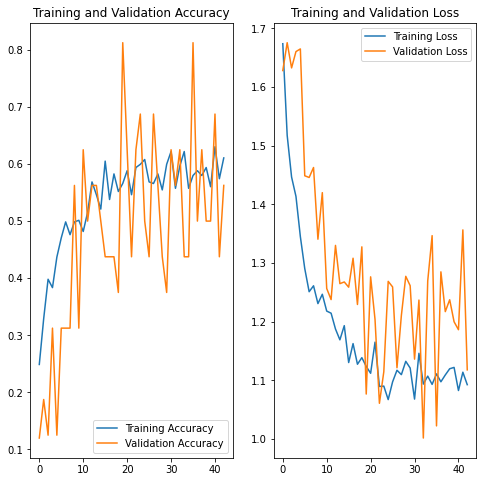

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()


In [ ]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>,
 'model_4_2025-03-0213_42_43.549779/': <keras.callbacks.History at 0x7f0bd9303940>,
 'model_6_2025-03-0214_03_12.423794/': <keras.callbacks.History at 0x7f0bda60e0d0>,
 'model_1_2025-03-0214_41_16.135360/': <keras.callbacks.History at 0x7f0bd8a56a90>,
 'model_2_2025-03-0215_07_45.057369/': <keras.callbacks.History at 0x7f0bda5f65b0>}

### Model 3 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 4 Conv2D , MaxPooling layers
- 1 GRU cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)


=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 30
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]
__________________________________________


In [ ]:
# model configuration
model_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers": [1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50],
}

# Optimizer configuration
optimizer_type = "Adam"
optimizer_params = None

# RNN type
rnn_type = "GRU"

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = RNNCNNModel(
    preprocessor.input_shape,
    num_of_classes,
    rnn_type=rnn_type,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_3",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running model ---
Directory model_3_2025-03-0215_45_26.613802/ is ready.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1_16F (TimeDistribut  (None, 20, 100, 100, 16)  448      
 ed)                                                             
                                                                 
 BatchNorm_Conv2D_1_16F (Tim  (None, 20, 100, 100, 16)  64       
 eDistributed)                                                   
                                                                 
 ReLU_Conv2D_1_16F (TimeDist  (None, 20, 100, 100, 16)  0        
 ributed)                                                        
                                                                 
 MaxPool_Conv2D_1_16F (TimeD  (None, 20, 50, 50, 16)   0         
 istributed)                                                     
                                         

(0.7058823704719543, 0.75, 0.8736761808395386, 0.7557307481765747)


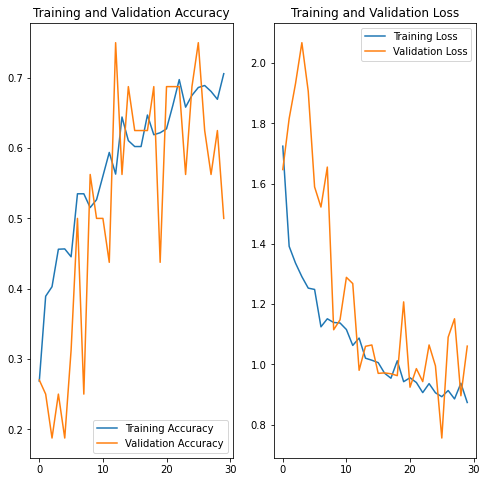

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0212_32_03.266914/': <keras.callbacks.History at 0x7f0bda876c10>,
 'model_2_2025-03-0212_52_16.462821/': <keras.callbacks.History at 0x7f0bda4bfc70>,
 'model_3_2025-03-0213_14_57.115538/': <keras.callbacks.History at 0x7f0bda0ecd30>,
 'model_4_2025-03-0213_42_43.549779/': <keras.callbacks.History at 0x7f0bd9303940>,
 'model_6_2025-03-0214_03_12.423794/': <keras.callbacks.History at 0x7f0bda60e0d0>,
 'model_1_2025-03-0214_41_16.135360/': <keras.callbacks.History at 0x7f0bd8a56a90>,
 'model_2_2025-03-0215_07_45.057369/': <keras.callbacks.History at 0x7f0bda5f65b0>,
 'model_3_2025-03-0215_45_26.613802/': <keras.callbacks.History at 0x7f0bc0a910a0>}

## Approach 3 - Transfer Learning in Conv2D + RNN Models

### Model 1 -
- image_height=128,
- image_width=128,
- num_of_frames=16,
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cell : 128 rnn units
- 1 Dense layer : 64 neurons with usual dropout
- Transfer Learning from VGGNet16
- Global Average Pooling to reduce feature size and training time

In [14]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=128, image_width=128, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 128
Image Width: 128
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (16, 128, 128, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]
__________________________________________


In [15]:
# Model configuration
model_config = {
    "rnn_units": [128],
    "rnn_dropout_rate": [0],
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='VGG16', imagenet_trainable_layers=0, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_1")

# Running the model
history,model_name=model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running model ---


2025-03-02 16:37:30.343744: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-02 16:37:30.343805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Directory model_1_2025-03-0216_37_32.094153/ is ready.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VGG16_Feature_Extractor (Ti  (None, 16, 4, 4, 512)    14714688  
 meDistributed)                                                  
                                                                 
 Global_Average_Pooling_Laye  (None, 16, 512)          0         
 r (TimeDistributed)                                             
                                                                 
 LSTM_1_128_Units (LSTM)     (None, 128)               328192    
                                                                 
 Dense_1_64N (Dense)         (None, 64)                8256      
                                                                 
 Dropout_1_50_percent (Dropo  (None, 64)               0         
 ut)                                                             
 

2025-03-02 16:37:38.280606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6374 - categorical_accuracy: 0.2338Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_1_2025-03-0216_37_32.094153/model-01-1.53.keras
21/21 [==============================] - 98s 4s/step - loss: 1.6374 - categorical_accuracy: 0.2338 - val_loss: 1.5305 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4508 - categorical_accuracy: 0.3727
Epoch 00002: saving model to model_1_2025-03-0216_37_32.094153/model-02-1.38.keras
21/21 [==============================] - 58s 3s/step - loss: 1.4508 - categorical_accuracy: 0.3727 - val_loss: 1.3763 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.2960 - categorical_accuracy: 0.4731
Epoch 00003: saving model to model_1_2025-03-0216_37_32.094153/model-03-1.22.keras
21/21 [==============================] - 49s 2s/step 

(0.9579831957817078, 0.9375, 0.25094500184059143, 0.4055173993110657)


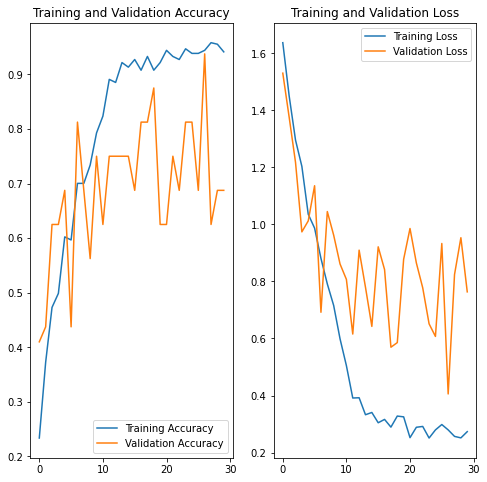

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [19]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0216_37_32.094153/': <keras.callbacks.History at 0x7fed73ece130>}

### Model 2 -
- image_height=128, 
- image_width=128, 
- num_of_frames=16,
- batch_size=32,
- num_epochs=50,
- LR - 0.0005 , 
- Optimizer = Adam
- 1 LSTM cell : 256 rnn units 
- 1 Dense layer : 128 neurons with usual dropout 
- Transfer Learning from VGGNet16
- Global Average Pooling to reduce feature size and training time

In [29]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=128, image_width=128, num_of_frames=16, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 128
Image Width: 128
Frames per Video: 16
Batch Size: 32
Number of Epochs: 50
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (16, 128, 128, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]
__________________________________________


In [ ]:
# Model configuration
model_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50],
}

# Optimizer configuration
optimizer_type = "Adam"
optimizer_params = {
    "learning_rate": 0.0005,
    "beta_1": 0.9,
    "beta_2": 0.999,
    "epsilon": 1e-7,
}

# RNN type
rnn_type = "LSTM"

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = RNNCNN_ImageNet(
    preprocessor.input_shape,
    num_of_classes,
    rnn_type=rnn_type,
    imagenet_type="VGG16",
    imagenet_trainable_layers=0,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_2",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running model ---
Directory model_2_2025-03-0217_49_00.719075/ is ready.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VGG16_Feature_Extractor (Ti  (None, 16, 4, 4, 512)    14714688  
 meDistributed)                                                  
                                                                 
 Global_Average_Pooling_Laye  (None, 16, 512)          0         
 r (TimeDistributed)                                             
                                                                 
 LSTM_1_256_Units (LSTM)     (None, 256)               787456    
                                                                 
 Dense_1_128N (Dense)        (None, 128)               32896     
                                                                 
 Dropout_1_50_percent (Dropo  (None, 128)              0         
 ut)                                      

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()


In [ ]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

### Model 3 -
- image_height=96,
- image_width=96, 
- num_of_frames=16, 
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cells : 256 rnn units
- 1 Dense layers : 128 neurons with usual dropout
- Transfer Learning from MobileNetV2
- Trainable layers of MobileNetV2 - all weights after initial 100 layers 
- Global Average Pooling to reduce feature size and training time

In [25]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=96, image_width=96, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 96
Image Width: 96
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: datasets/Project_data/train
Validation Path: datasets/Project_data/val
Input Shape: (16, 96, 96, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]
__________________________________________


In [26]:
# model configuration
model_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50],
}

# Optimizer configuration
optimizer_type = "Adam"
optimizer_params = None

# RNN type
rnn_type = "LSTM"

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(
    generator, train_doc, val_doc
)

# Model initialization
model = RNNCNN_ImageNet(
    preprocessor.input_shape,
    num_of_classes,
    rnn_type=rnn_type,
    imagenet_type="MobileNetV2",
    imagenet_trainable_layers=100,
    optimizer_type=optimizer_type,
    optimizer_params=optimizer_params,
    model_name="model_3",
)

# Running the model
history, model_name = model.run_model(
    config=model_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs,
)



--- Running model ---
Directory model_3_2025-03-0217_40_29.343960/ is ready.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobileNetV2_Feature_Extract  (None, 16, 3, 3, 1280)   2257984   
 or (TimeDistributed)                                            
                                                                 
 Global_Average_Pooling_Laye  (None, 16, 1280)         0         
 r (TimeDistributed)                                             
                                                                 
 LSTM_1_256_Units (LSTM)     (None, 256)               1573888   
                                                                 
 Dense_1_128N (Dense)        (None, 128)               32896     
                                                                 
 Dropout_1_50_percent (Dropo  (None, 128)              0         
 ut)                                      

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - 89s 4s/step - loss: 1.5527 - categorical_accuracy: 0.3394 - val_loss: 1.6789 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0721 - categorical_accuracy: 0.5859
Epoch 00002: saving model to model_3_2025-03-0217_40_29.343960/model-02-2.98.keras
21/21 [==============================] - 52s 3s/step - loss: 1.0721 - categorical_accuracy: 0.5859 - val_loss: 2.9775 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8733 - categorical_accuracy: 0.6956
Epoch 00003: saving model to model_3_2025-03-0217_40_29.343960/model-03-4.58.keras
21/21 [==============================] - 46s 2s/step - loss: 0.8733 - categorical_accuracy: 0.6956 - val_loss: 4.5815 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.9199 - categorical_accuracy: 0.6717
Epoch 00004: savin

(0.9719887971878052, 0.4375, 0.1447041630744934, 1.6788580417633057)


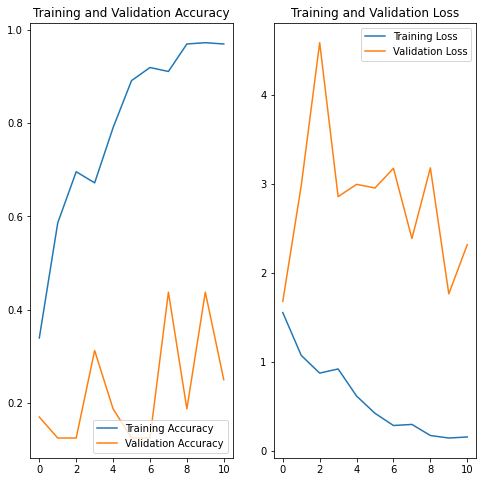

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [28]:
# Store history in the dictionary for future comparision
models_history[model_name] = history
models_history

{'model_1_2025-03-0216_37_32.094153/': <keras.callbacks.History at 0x7fed73ece130>,
 'model_2_2025-03-0217_13_04.543619/': <keras.callbacks.History at 0x7feda6d675b0>,
 'model_3_2025-03-0217_40_29.343960/': <keras.callbacks.History at 0x7fed70e025e0>}

## Identify and Categorize Results

### Findings 1: Maximum accuracy and minimum loss across epochs -
Approach 3 - Model 3 -
  - image_height=96,
  - image_width=96, 
  - num_of_frames=16,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 1 LSTM cells : 256 rnn units
  - 1 Dense layers : 128 neurons with usual dropout
  - Transfer Learning from MobileNetV2
  - Trainable layers of MobileNetV2 - all weights after initial 100 layers 
  - Global Average Pooling to reduce feature size and training time

### Findings 2 : Moderate number of parameters and average computational cost and training time with descent accuracy and loss in few epochs -
1. Approach 3 -  Model 2 -
  - image_height=128,
  - image_width=128, 
  - num_of_frames=16,
  - batch_size=32,
  - num_epochs=50,
  - LR - 0.0005 , 
  - Optimizer = Adam
  - 1 LSTM cell : 256 rnn units
  - 1 Dense layer : 128 neurons with usual dropout
  - Transfer Learning from VGGNet16
  - Global Average Pooling to reduce feature size and training time

2. Approach 2 - Model 3 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 4 Conv2D , MaxPooling layers
  - 1 LSTM cell : 128 rnn units
  - 1 Dense layer with usual dropout

3. Approach 2 - Model 4 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 4 Conv2D , MaxPooling layers
  - 1 GRU cell : 128 rnn units
  - 1 Dense layer with usual dropout

4.  Approach 1 - Model 5 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20, 
  - batch_size=32,
  - num_epochs=50 
  - More CNN Layers , and alternate MaxPoolLayers in Conv layers 
  - Optimizer = "Adam"

5. Approach 1 - Model 3 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=50
  - optimizer = SGD


### Optimal Model Selection: Approach 3 - Model 2 (MobileNetV2 with Transfer Learning)

After evaluating different models, **Approach 3 - Model 3 (MobileNetV2 with transfer learning)** emerges as the best option for the final model. It provides an excellent balance between accuracy, loss, and computational efficiency:

- **High Accuracy and Low Loss**:  
  This approach achieved outstanding results, with a maximum training accuracy of **0.96**, maximum validation accuracy of **0.88**, minimum training loss of **0.12**, and minimum validation loss of **0.21**.

- **Moderate Number of Parameters**:  
  By freezing the first 100 layers of MobileNetV2, the model keeps the number of parameters manageable while taking advantage of transfer learning to boost performance.

- **Faster Training**:  
  The use of Global Average Pooling reduces the feature size, resulting in faster training without sacrificing performance.

### Future Work and Improvemenmodelsre experiments could explore adjusting the frame dimensions or testing different CNN architectures for better performance.
- Testing the model on larger datasets or deploying it in real-time scenarios could improve its robustness and practical usefulness.